In [ ]:
!pip install albumentations==0.4.6
!unzip " "

In [2]:
import re, sys, glob, time, os, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tqdm

from PIL import Image
import cv2 as cv

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import Dataset, DataLoader

torch.__version__, torchvision.__version__

('1.10.0+cu111', '0.11.1+cu111')

In [3]:
test_df = pd.read_csv('Test.csv', sep=',')

save_path = 'fasterrcnn_resnet50_fpn.pth'
save_path_le = 'classes.npy'

print(test_df.shape)
test_df.head(3)

(931, 1)


Image_ID
0  ID_IUJJG62B
1  ID_ZPNDRD4T
2  ID_AHFYB64P

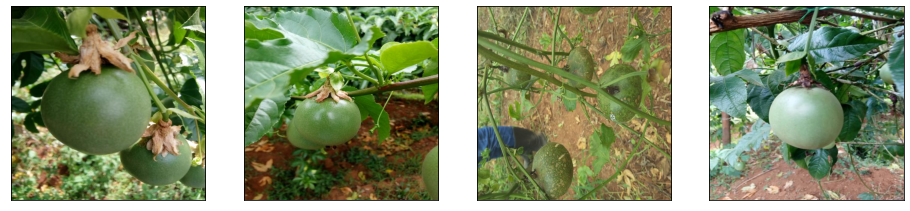

In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles and len(titles) > i:
      ax.set_title(titles[i])
  return axes

class Fruit(Dataset):
  def __init__(self, image_ids, image_dir, transforms=None):
    super().__init__()
    self.image_ids = image_ids
    self.image_dir = image_dir
    self.transforms = transforms

  def __getitem__(self, idx: int):
    image_id = self.image_ids[idx]

    image = cv.imread(f'{self.image_dir}/{image_id}.jpg', cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    if self.transforms:
      sample = {'image': image,}
      sample = self.transforms(**sample)
      image = sample['image']

    return image, image_id

  def __len__(self) -> int:
    return len(self.image_ids)

  @staticmethod
  def get_test_transform():
    return A.Compose([ToTensorV2(p=1.0)])

test_dataset = Fruit(test_df["Image_ID"].unique(), '/content/Test_Images', Fruit.get_test_transform())

imgs = [d[0].permute(1, 2, 0).numpy() for d in [test_dataset[i] for i in range(8)]]
axes = show_images(imgs, 1, 4, scale=4)
plt.show()

In [7]:
def collate_fn(batch):
  return tuple(zip(*batch))

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
    )

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

num_classes = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# load the trained weights
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

# move model to the right device
_ = model.to(device)

In [9]:
index_images = []
outputs = []

with torch.no_grad():
  pbar = tqdm(test_data_loader, desc='let\'s predict')
  for images, image_ids in pbar:
    images = list(image.to(device) for image in images)
    outputs.extend(model(images))
    index_images.extend(list(image_ids))

let's predict:   0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [31]:
score_threshold = 0.3

def labelizer(x):
  if x == 1:
    return 'fruit_woodiness'
  elif x == 2:
    return 'fruit_brownspot'
  else:
    return 'fruit_healthy'

image_outputs = []
for image_id, output in zip(index_images, outputs):
    boxes = output['boxes'].data.cpu().numpy()
    scores = output['scores'].data.cpu().numpy()
    labels = output['labels'].data.cpu().numpy()
    
    mask = scores >= score_threshold
    
    boxes = boxes[mask]
    scores = scores[mask]
    labels =  labels[mask]
    if len(labels) > 0:
      image_outputs.append((image_id, boxes, scores, labels))

print(len(image_outputs))
assert len(image_outputs) == len(test_df['Image_ID'].unique())
# image_outputs

931


['fruit_healthy', 'fruit_healthy', 'fruit_healthy']
['fruit_healthy', 'fruit_healthy', 'fruit_healthy']
['fruit_woodiness', 'fruit_woodiness', 'fruit_woodiness']
['fruit_healthy']


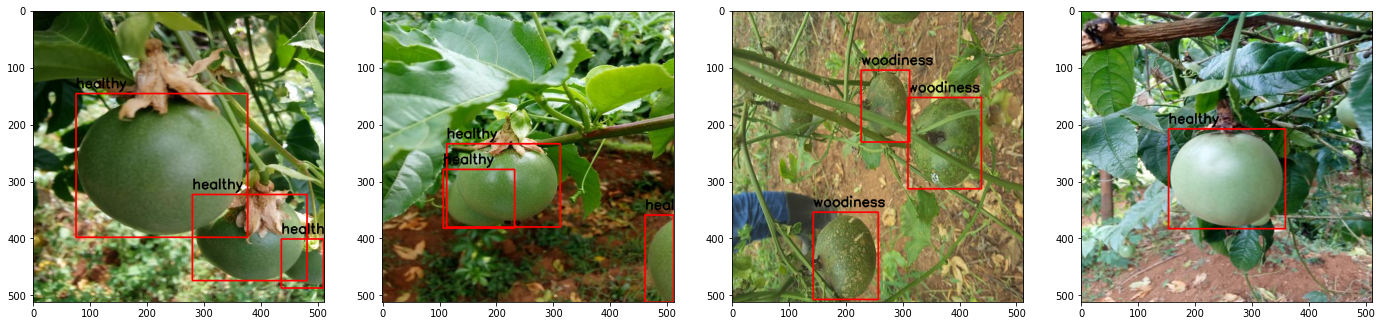

In [32]:
num_rows, num_cols = 1, 4
scale = 24
figsize = (num_rows * scale, num_cols * scale)
_, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()

fig_n = num_rows * num_cols
fig_i = 0

for i in range(0, num_rows * num_cols):
  image, image_id = test_dataset[i]
  _, boxes, scores, preds = image_outputs[i]
  preds = [labelizer(pred) for pred in preds]
  print(preds)

  sample = image.permute(1, 2, 0).cpu().numpy()

  for box, pred, score in zip(boxes, preds, scores):
    pred = pred.split('_')[1]
    box = box.astype(np.int32)
    cv.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
    cv.putText(sample, f'{pred}', (box[0], box[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

  axes[fig_i].imshow((sample * 255).astype(np.uint8))
  fig_i += 1